In [1]:
import os

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import faiss
import torch
import umap
from ogb.nodeproppred import DglNodePropPredDataset
from sklearn.decomposition import PCA

Using backend: pytorch


In [3]:
dataset = DglNodePropPredDataset('ogbn-arxiv', root='../../data/dataset_dgl')
graph = dataset[0][0]

In [4]:
output_emb_file = '../../models/graphsage_link_pred/full_cos_graphsage_linkpred_24_h.npy'

In [5]:
embeddings = np.load(output_emb_file)
embeddings.shape

(169343, 50)

## L2 Distance

In [6]:
index = faiss.IndexFlatL2(embeddings.shape[1])

In [7]:
index.train(embeddings)
index.add(embeddings)

In [8]:
index

<faiss.swigfaiss.IndexFlatL2; proxy of <Swig Object of type 'faiss::IndexFlatL2 *' at 0x7f2948035570> >

In [9]:
index.ntotal

169343

### Check if the closest embedding is a neighbor

In [10]:
distances, indices = index.search(embeddings, 2)

In [11]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(12277)

In [12]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [13]:
max_k = 100
distances, indices = index.search(embeddings, max_k + 1)

In [14]:
has_neighbor = torch.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [15]:
has_neighbor

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

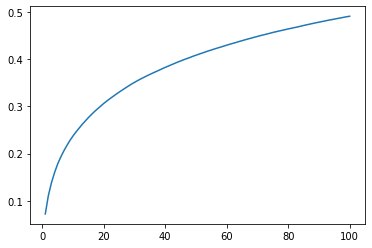

In [16]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

In [17]:
percentages

tensor([0.0725, 0.1114, 0.1383, 0.1595, 0.1776, 0.1923, 0.2054, 0.2169, 0.2276,
        0.2372, 0.2459, 0.2538, 0.2618, 0.2688, 0.2760, 0.2826, 0.2889, 0.2946,
        0.3002, 0.3060, 0.3111, 0.3160, 0.3207, 0.3254, 0.3298, 0.3342, 0.3385,
        0.3427, 0.3468, 0.3505, 0.3542, 0.3577, 0.3610, 0.3643, 0.3674, 0.3704,
        0.3734, 0.3762, 0.3793, 0.3823, 0.3849, 0.3878, 0.3905, 0.3933, 0.3958,
        0.3984, 0.4008, 0.4031, 0.4057, 0.4080, 0.4103, 0.4125, 0.4146, 0.4170,
        0.4190, 0.4211, 0.4232, 0.4250, 0.4272, 0.4291, 0.4312, 0.4330, 0.4348,
        0.4369, 0.4387, 0.4406, 0.4424, 0.4442, 0.4460, 0.4477, 0.4495, 0.4510,
        0.4527, 0.4543, 0.4561, 0.4575, 0.4591, 0.4605, 0.4620, 0.4636, 0.4649,
        0.4663, 0.4677, 0.4692, 0.4708, 0.4723, 0.4737, 0.4751, 0.4765, 0.4778,
        0.4791, 0.4805, 0.4818, 0.4830, 0.4842, 0.4856, 0.4867, 0.4881, 0.4893,
        0.4904])

In [18]:
percentages.max()

tensor(0.4904)

### Percentage of same class neighbors by neighborhood size

In [19]:
y = dataset[0][1][:, 0]

In [20]:
label_dict = {idx: val for idx, val in enumerate(y.numpy())}

In [21]:
label_transform = np.vectorize(label_dict.get)

In [22]:
ind_labels = label_transform(indices)

In [23]:
is_same_class = np.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    is_same_class[:, j] = (ind_labels[:, 0] == ind_labels[:, j + 1]) * 1

In [24]:
n_same_class = is_same_class.sum(axis=0).cumsum()
n_total = np.array([is_same_class.shape[0] * i for i in range(1, max_k + 1)])

In [25]:
perc_same_class = n_same_class / n_total

In [26]:
perc_same_class

array([0.4883048 , 0.47259704, 0.46243226, 0.455007  , 0.44935899,
       0.44471871, 0.44090228, 0.43756385, 0.43477177, 0.43216076,
       0.42989672, 0.42779891, 0.42600839, 0.42431675, 0.42281563,
       0.42140139, 0.42016742, 0.41897018, 0.41777775, 0.41667208,
       0.41560282, 0.41454085, 0.41358791, 0.41270257, 0.41186586,
       0.41103218, 0.41033419, 0.40961666, 0.4089195 , 0.40825406,
       0.40761307, 0.40697892, 0.40634241, 0.40574716, 0.40518474,
       0.4046439 , 0.40410834, 0.40355777, 0.40303378, 0.40252284,
       0.4019939 , 0.401473  , 0.40099762, 0.40053324, 0.4000916 ,
       0.39966133, 0.39925891, 0.3988729 , 0.39845938, 0.39803818,
       0.39762285, 0.39723929, 0.39689236, 0.39652089, 0.39617151,
       0.39580098, 0.39547318, 0.3951467 , 0.39478675, 0.39447039,
       0.39416664, 0.39386201, 0.39355374, 0.39324625, 0.39292742,
       0.39262567, 0.39232632, 0.39204854, 0.3917706 , 0.39150077,
       0.39122115, 0.39095636, 0.39068935, 0.39044664, 0.39020

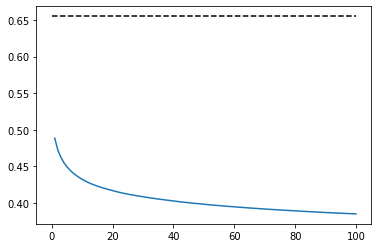

In [27]:
plt.plot(list(range(1, max_k + 1)), perc_same_class)
plt.hlines(0.6551, 0, max_k, color='black', ls='--')

## Cossine Distance

In [28]:
emb_norm = embeddings / np.linalg.norm(embeddings, axis=1)[:, None]

In [29]:
index_cos = faiss.IndexFlatIP(emb_norm.shape[1])

In [30]:
index_cos.train(emb_norm)
index_cos.add(emb_norm)

In [31]:
index_cos

<faiss.swigfaiss.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x7f2870045d80> >

In [32]:
index_cos.ntotal

169343

### Check if the closest embedding is a neighbor

In [33]:
distances, indices = index_cos.search(emb_norm, 2)

In [34]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(12564)

In [35]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [36]:
(sum(emb_norm[0] * emb_norm[411]) + 1) / 2

0.8513485075891367

In [37]:
max_k = 100
distances, indices = index_cos.search(emb_norm, max_k + 1)

In [38]:
indices

array([[     0,  78524,  44447, ...,  15212, 163182,  52441],
       [     1, 154949,  14127, ...,  80308, 152611, 165357],
       [     2,  87117, 168209, ..., 135422,   7739,  47863],
       ...,
       [169340,  46791,  61604, ...,  53478,  81672, 112925],
       [169341,   5037, 101242, ..., 149543, 105380,  70820],
       [169342, 168419, 121872, ..., 116582,  15999, 106605]])

In [39]:
sum(emb_norm[0] * emb_norm[411])

0.7026970151782734

In [40]:
distances

array([[0.99999994, 0.99907845, 0.9984316 , ..., 0.9933879 , 0.99330854,
        0.99329686],
       [1.        , 0.99963903, 0.996993  , ..., 0.98857117, 0.98854613,
        0.9884955 ],
       [0.9999999 , 0.9996453 , 0.99940616, ..., 0.99598217, 0.9959596 ,
        0.9958985 ],
       ...,
       [1.        , 0.99720246, 0.9967332 , ..., 0.99151635, 0.99148387,
        0.9914429 ],
       [1.        , 0.99973   , 0.9997252 , ..., 0.9988678 , 0.9988592 ,
        0.9988571 ],
       [1.        , 0.9993614 , 0.9989902 , ..., 0.9940797 , 0.99407756,
        0.99407655]], dtype=float32)

In [41]:
has_neighbor = torch.zeros((emb_norm.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [42]:
has_neighbor

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

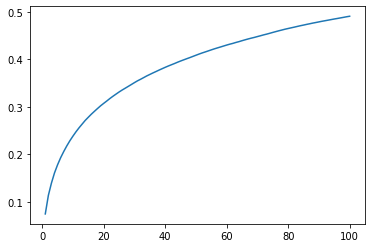

In [43]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

In [44]:
percentages

tensor([0.0742, 0.1132, 0.1391, 0.1606, 0.1777, 0.1927, 0.2056, 0.2175, 0.2284,
        0.2381, 0.2473, 0.2558, 0.2635, 0.2712, 0.2779, 0.2844, 0.2904, 0.2963,
        0.3020, 0.3071, 0.3120, 0.3172, 0.3220, 0.3265, 0.3310, 0.3352, 0.3390,
        0.3429, 0.3468, 0.3508, 0.3545, 0.3578, 0.3613, 0.3648, 0.3680, 0.3711,
        0.3741, 0.3771, 0.3801, 0.3830, 0.3857, 0.3883, 0.3909, 0.3937, 0.3962,
        0.3987, 0.4011, 0.4034, 0.4059, 0.4084, 0.4109, 0.4132, 0.4153, 0.4175,
        0.4198, 0.4219, 0.4239, 0.4259, 0.4279, 0.4299, 0.4317, 0.4334, 0.4354,
        0.4371, 0.4391, 0.4410, 0.4428, 0.4444, 0.4460, 0.4478, 0.4495, 0.4513,
        0.4529, 0.4547, 0.4565, 0.4583, 0.4600, 0.4616, 0.4633, 0.4648, 0.4662,
        0.4676, 0.4692, 0.4706, 0.4720, 0.4734, 0.4747, 0.4761, 0.4774, 0.4787,
        0.4800, 0.4811, 0.4823, 0.4835, 0.4848, 0.4859, 0.4871, 0.4882, 0.4895,
        0.4906])

### Percentage of same class neighbors by neighborhood size

In [45]:
ind_labels = label_transform(indices)

In [46]:
is_same_class = np.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    is_same_class[:, j] = (ind_labels[:, 0] == ind_labels[:, j + 1]) * 1

In [47]:
n_same_class = is_same_class.sum(axis=0).cumsum()
n_total = np.array([is_same_class.shape[0] * i for i in range(1, max_k + 1)])

In [48]:
perc_same_class = n_same_class / n_total

In [49]:
perc_same_class

array([0.49234985, 0.47671294, 0.46671745, 0.45924987, 0.45383039,
       0.44952946, 0.44595711, 0.44290951, 0.44020584, 0.43783682,
       0.4356752 , 0.43371983, 0.43203212, 0.43035015, 0.42893654,
       0.42763836, 0.42641718, 0.42531955, 0.42412954, 0.42308746,
       0.42206224, 0.42120806, 0.42030235, 0.41945292, 0.4186646 ,
       0.41795873, 0.41722771, 0.41653078, 0.41588028, 0.41525425,
       0.41466194, 0.41401567, 0.41344061, 0.41284865, 0.41229221,
       0.4117639 , 0.4112378 , 0.41071733, 0.41025762, 0.40979329,
       0.40935262, 0.40892688, 0.40850103, 0.40805898, 0.40765691,
       0.40728632, 0.40693137, 0.40652576, 0.40614116, 0.40579983,
       0.4054537 , 0.40508635, 0.40472675, 0.40440353, 0.40405771,
       0.40374491, 0.40340869, 0.40312785, 0.40281299, 0.40250409,
       0.4022061 , 0.40191552, 0.4016533 , 0.40137233, 0.40113588,
       0.40090813, 0.40066073, 0.40041044, 0.40014585, 0.39988586,
       0.3996342 , 0.39939001, 0.39914411, 0.39893014, 0.39868

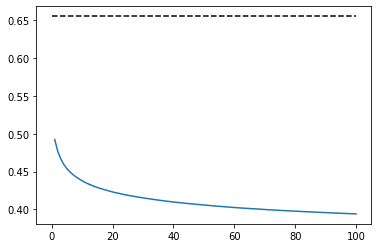

In [50]:
plt.plot(list(range(1, max_k + 1)), perc_same_class)
plt.hlines(0.6551, 0, max_k, color='black', ls='--')

## Inner Product

In [51]:
index_ip = faiss.IndexFlatIP(embeddings.shape[1])

In [52]:
index_ip.train(embeddings)
index_ip.add(embeddings)

In [53]:
index_ip

<faiss.swigfaiss.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x7f28604bfbd0> >

In [54]:
index_ip.ntotal

169343

### Check if the closest embedding is a neighbor

In [55]:
distances, indices = index_ip.search(embeddings, 2)

In [56]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(4601)

In [57]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [58]:
(sum(embeddings[0] * embeddings[411]) + 1) / 2

5411.22023832798

In [59]:
max_k = 100
distances, indices = index_ip.search(embeddings, max_k + 1)

In [60]:
indices

array([[ 77580, 127414,  88038, ..., 118726, 111990,  29721],
       [115222, 110100,  83074, ..., 141889, 100849, 136572],
       [144482,   5667, 127345, ..., 100772,   2668,  86090],
       ...,
       [119721,  59107, 104017, ...,  12461, 128180,  95184],
       [  3715, 127414,  77580, ...,    508,  80016, 107941],
       [ 42413,  12290, 124984, ...,  36142, 101754,  12425]])

In [61]:
sum(embeddings[0] * embeddings[411])

10821.44047665596

In [62]:
distances

array([[54781.16  , 54217.52  , 54001.043 , ..., 44283.164 , 44213.008 ,
        44202.613 ],
       [53049.855 , 52625.027 , 52080.066 , ..., 44062.637 , 43988.066 ,
        43974.527 ],
       [84959.23  , 82825.26  , 80986.58  , ..., 71128.4   , 71088.26  ,
        71074.695 ],
       ...,
       [ 4218.0366,  4210.5137,  4185.903 , ...,  3190.1912,  3189.8083,
         3180.7039],
       [75552.414 , 74966.79  , 72216.01  , ..., 60301.53  , 60289.395 ,
        60288.34  ],
       [74756.055 , 71201.766 , 70635.055 , ..., 59722.395 , 59709.555 ,
        59706.586 ]], dtype=float32)

In [63]:
has_neighbor = torch.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [64]:
has_neighbor

tensor([[0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.]])

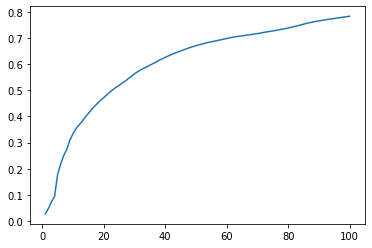

In [65]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

In [66]:
percentages

tensor([0.0272, 0.0480, 0.0732, 0.0932, 0.1774, 0.2182, 0.2512, 0.2736, 0.3096,
        0.3339, 0.3538, 0.3679, 0.3813, 0.3977, 0.4114, 0.4257, 0.4392, 0.4508,
        0.4620, 0.4723, 0.4826, 0.4934, 0.5026, 0.5115, 0.5190, 0.5272, 0.5355,
        0.5450, 0.5535, 0.5630, 0.5710, 0.5780, 0.5843, 0.5901, 0.5963, 0.6023,
        0.6080, 0.6149, 0.6206, 0.6261, 0.6317, 0.6369, 0.6415, 0.6461, 0.6505,
        0.6549, 0.6593, 0.6637, 0.6673, 0.6710, 0.6744, 0.6774, 0.6805, 0.6834,
        0.6859, 0.6884, 0.6908, 0.6933, 0.6957, 0.6985, 0.7012, 0.7033, 0.7052,
        0.7070, 0.7087, 0.7103, 0.7120, 0.7137, 0.7154, 0.7172, 0.7193, 0.7217,
        0.7237, 0.7255, 0.7274, 0.7295, 0.7318, 0.7339, 0.7362, 0.7386, 0.7414,
        0.7441, 0.7469, 0.7502, 0.7533, 0.7567, 0.7591, 0.7615, 0.7638, 0.7658,
        0.7679, 0.7697, 0.7718, 0.7733, 0.7751, 0.7770, 0.7786, 0.7803, 0.7820,
        0.7836])

### Percentage of same class neighbors by neighborhood size

In [67]:
ind_labels = label_transform(indices)

In [68]:
is_same_class = np.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    is_same_class[:, j] = (ind_labels[:, 0] == ind_labels[:, j + 1]) * 1

In [69]:
n_same_class = is_same_class.sum(axis=0).cumsum()
n_total = np.array([is_same_class.shape[0] * i for i in range(1, max_k + 1)])

In [70]:
perc_same_class = n_same_class / n_total

In [71]:
perc_same_class

array([0.54301034, 0.5500375 , 0.545709  , 0.54198579, 0.5397247 ,
       0.5333544 , 0.52964271, 0.52759783, 0.5272783 , 0.52732147,
       0.52511659, 0.52324031, 0.52041532, 0.51855026, 0.5171378 ,
       0.51571515, 0.51547416, 0.51616148, 0.51648989, 0.51659059,
       0.5166159 , 0.51639491, 0.51604885, 0.5156556 , 0.51532192,
       0.51491329, 0.51467425, 0.51442529, 0.51416865, 0.5135258 ,
       0.5128829 , 0.51200965, 0.51112472, 0.51016246, 0.50924776,
       0.50860597, 0.50790041, 0.50726694, 0.50671986, 0.50621756,
       0.5056591 , 0.50503219, 0.50441686, 0.50379824, 0.50319634,
       0.50258185, 0.50206109, 0.50144443, 0.50075496, 0.50001772,
       0.49933266, 0.49867031, 0.49802249, 0.49739462, 0.49677604,
       0.4961919 , 0.49557241, 0.49499587, 0.49448982, 0.49402633,
       0.4936061 , 0.49313142, 0.4927185 , 0.4923003 , 0.49190968,
       0.49149342, 0.49107918, 0.4907162 , 0.49032745, 0.48994475,
       0.48950996, 0.48910503, 0.48869325, 0.48832571, 0.48787

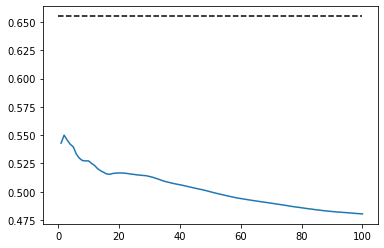

In [72]:
plt.plot(list(range(1, max_k + 1)), perc_same_class)
plt.hlines(0.6551, 0, max_k, color='black', ls='--')

## Scatter Plot PCA 2dim

In [73]:
pca = PCA(n_components=2)

In [74]:
pca.fit(embeddings)

PCA(n_components=2)

In [75]:
emb_2d = pca.transform(embeddings)

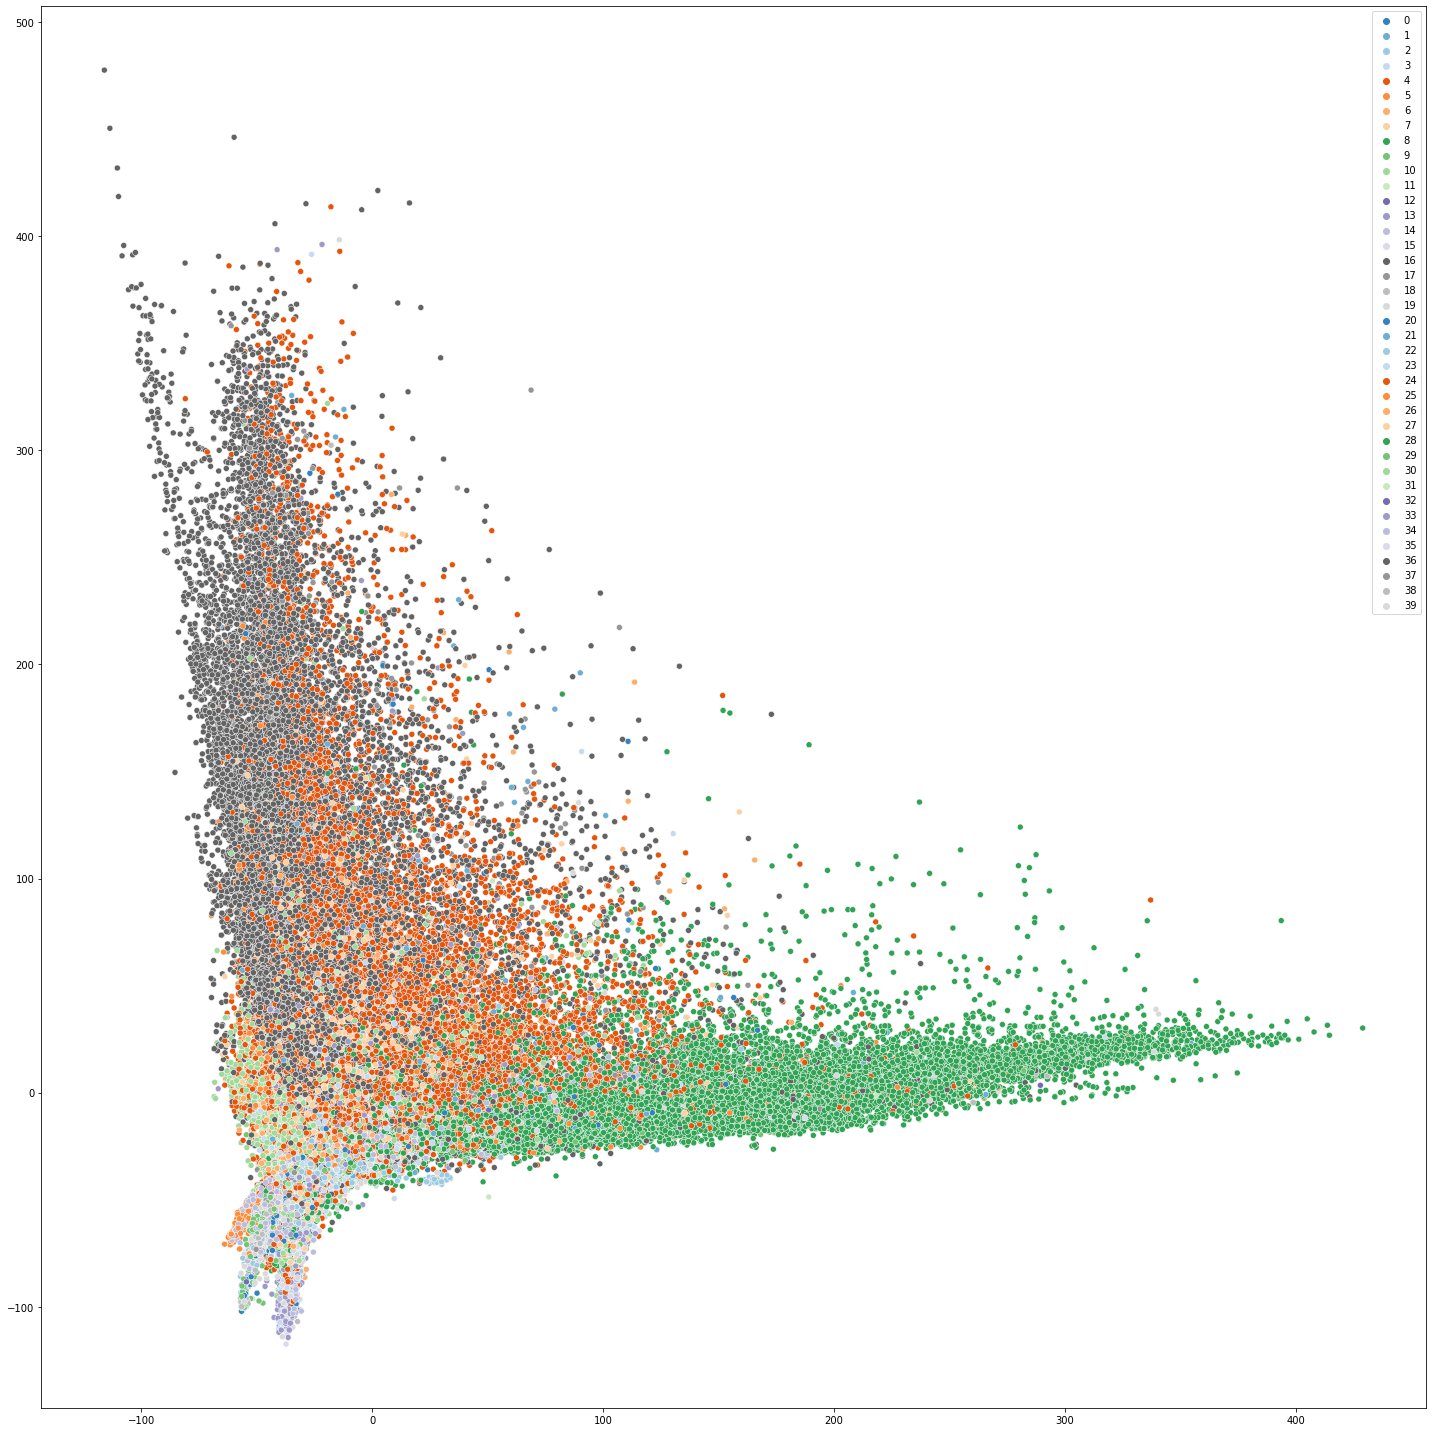

In [76]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x=emb_2d[:,0], y=emb_2d[:,1], hue=dataset[0][1][:,0], palette='tab20c')
plt.tight_layout()

## Scatter Plot UMAP 2d

In [77]:
emb_umap_2d = umap.UMAP(n_components=2).fit_transform(embeddings)

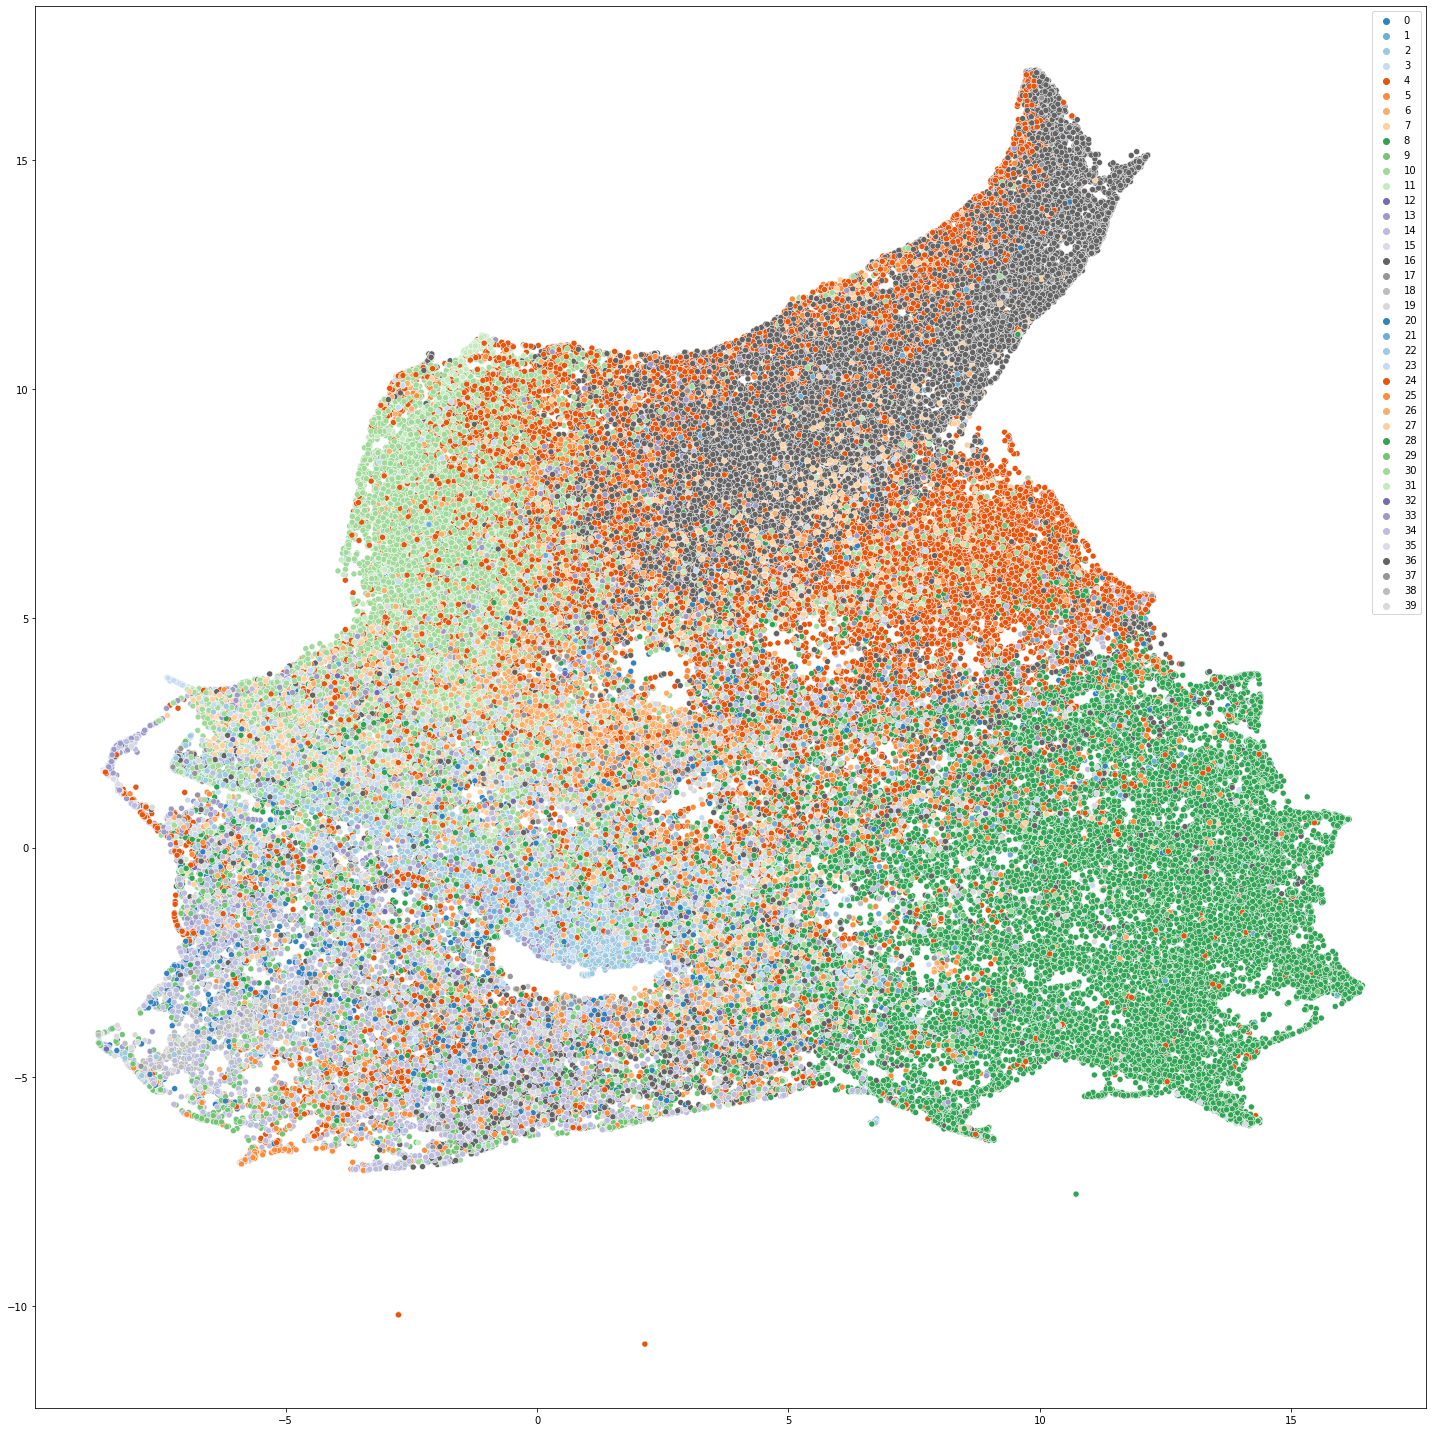

In [78]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x=emb_umap_2d[:,0], y=emb_umap_2d[:,1], hue=dataset[0][1][:,0], palette='tab20c')
plt.tight_layout()

## Scatter Plot UMAP 2d - Normalized embeddings

In [79]:
emb_umap_2d_norm = umap.UMAP(n_components=2).fit_transform(emb_norm)

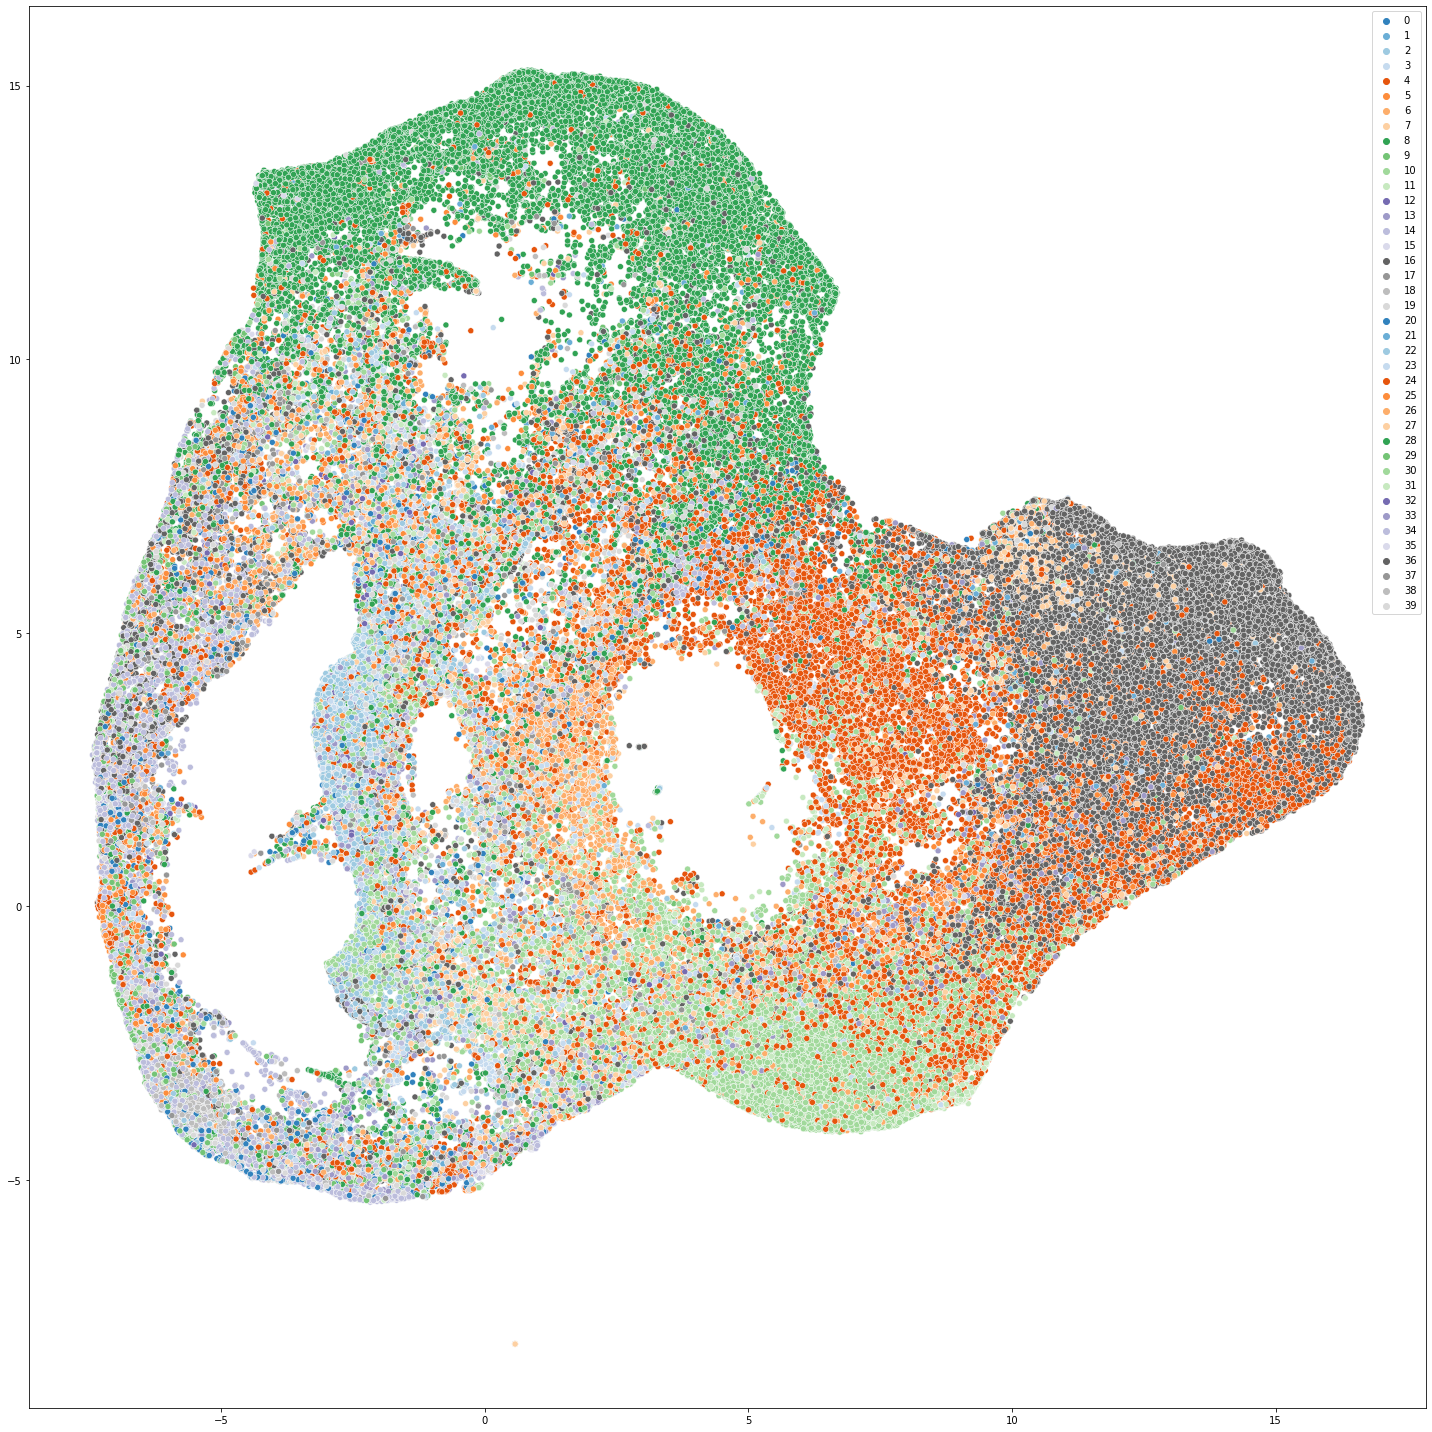

In [80]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x=emb_umap_2d_norm[:,0], y=emb_umap_2d_norm[:,1], hue=dataset[0][1][:,0], palette='tab20c')
plt.tight_layout()